In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import hamming_loss, make_scorer
from sklearn import preprocessing

import time
import math

In [112]:
# helper functions here

# Problem 1 - part b - sec i - passive learning
# Return 90 test errors of 90 SVMs trained on 10, 20, 30 ... 900 data
def procedure_1bi(train_data, test_data):
    # instead of select 10 random points in training at a time
    # shuffle the entire train data set
    # select 10, 20, 30, etc. of the shuffled data set
    # no repeats in each selection
    np.random.shuffle(train_data)

    data = train_data[:,:4]
    label = train_data[:,4]

    # parameter from 10^-3 to 10^6 up to 20 values log scale
    penalty_list = np.logspace(-3, 6, 20, endpoint=True)
    error_dict = {}
    it = 1
    for i in range(90):
        pool = 10*(i+1)
        X = data[:pool]
        y = label[:pool]

        # at each iteration, increase train size by 10, 20, 30 ... 900
        # dual=False when n_samples > n_features.
        cv_dict = {}
        for c in penalty_list:
            clf = svm.LinearSVC(penalty='l1', dual=False, C=c)
            # 10-fold CV to select penalty parameter with best CV error
            # scores = cross_val_score(clf, X, y, cv=10, scoring='f1')
            kf = KFold(n_splits=10)
            scores = []
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                clf.fit(X_train, y_train)
                scores.append(clf.score(X_test, y_test))

            cv_dict[c] = np.average(np.array(scores))

        # best c with max mean accuracy score
        opt_c = max(cv_dict, key= cv_dict.get)
        # print("iter:", it, "cv result:", opt_c)

        # model with opt penalty parameter from CV
        clf = svm.LinearSVC(penalty='l1', dual=False, C=opt_c)
        clf.fit(X, y)

        # error in terms of mean accuracy score
        test_error = clf.score(test_data[:,:4], test_data[:,4])
        error_dict[it] = test_error
        # print("iter:", it, "test_error:", test_error)

        it += 1
    return error_dict


# Problem 1 - part b - sec ii - active learning
# Return 90 test errors of 90 SVMs trained on 10, 20, 30 ... 900 data
# builds training size based on closest to the hyperplane per iteration
def procedure_1bii(train_data, test_data):
    # initial state
    active_pool = train_data[:10]
    train_data = np.delete(train_data, np.s_[:10], axis=0)

    #active_pool = np.append(active_pool, train_data[:5], axis=0)
    #print("active_pool:", active_pool.shape[0])

    penalty_list = np.logspace(-3, 6, 20, endpoint=True)
    error_dict = {}
    for i in range(90):
        X = active_pool[:,:4]
        y = active_pool[:,4]

        kf = KFold(n_splits=10)
        cv_dict = {}
        for c in penalty_list:
            clf = svm.LinearSVC(penalty='l1', dual=False, C=c)
            # 10-fold CV to select penalty parameter with best CV error
            scores = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')
            cv_dict[c] = np.average(np.array(scores))
        opt_c = max(cv_dict, key= cv_dict.get)

        # model with opt penalty parameter from CV
        clf = svm.LinearSVC(penalty='l1', dual=False, C=opt_c)
        clf.fit(X, y)

        # error in terms of mean accuracy score
        test_error = clf.score(test_data[:,:4], test_data[:,4])
        error_dict[i+1] = test_error

        # ref: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
        # confidence score for a sample is the signed distance of that sample to the hyperplane.
        # decision_function() returns confidence score for samples X

        if(train_data.shape[0] != 0):
            candidate_support = clf.decision_function(train_data[:,:4])
            candidate_support = np.array([abs(i) for i in candidate_support])

            # sorted index list from closest to most far from hyperplace
            # index list of 10 closest to hyperplane
            candidate_index = np.argsort(candidate_support)[:10]

            # remove 10 closest from train_data
            # append it to the active_pool for next iteration
            active_pool = np.append(active_pool, train_data[candidate_index], axis=0)
            train_data = np.delete(train_data, np.s_[candidate_index], axis=0)
    return error_dict


def procedure_2bii(X, y):
    penalty_list = np.logspace(-3, 6, 20, endpoint=True) # penalty to cv
    sigma_list = np.arange(0.1, 2.1, 0.1) # width of rbf kernel
    scoring = make_scorer(hamming_loss)

    kf = KFold(n_splits=10)
    cv_dict = {}
    for p in penalty_list:
        for s in sigma_list:
            # print("cv:", p, s)
            clf = svm.SVC(C=p, kernel='rbf', gamma=s, decision_function_shape='ovr')
            scores = cross_val_score(clf, X, y, cv=kf, scoring=scoring)
            cv_dict[(p,s)] = np.average(np.array(scores))
            
    # arg with lowest hamming_loss value
    opt_p, opt_s = min(cv_dict, key= cv_dict.get)
    
    return opt_p, opt_s, cv_dict[(opt_p, opt_s)]

def get_test_error_2bii(X_train, y_train, X_test, y_test, p, s):
    clf = svm.SVC(C=p, kernel='rbf', gamma=s, decision_function_shape='ovr')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return hamming_loss(y_test, y_pred)

# handler for problem 2b sec iii
# return cv L1 penalty, cv error for L1 SVM
def procedure_2biii(X, y):
    # standarize features X to zero mean and unit variance
    X_scaled = preprocessing.scale(X)
    
    penalty_list = np.logspace(-3, 6, 20, endpoint=True) # penalty to cv
    scoring = make_scorer(hamming_loss)
    
    # 10-fold CV to select penalty parameter with best CV error    
    kf = KFold(n_splits=10)
    cv_dict = {}
    for p in penalty_list:
        # prefer dual=False when n_samples > n_features.
        clf = svm.LinearSVC(penalty='l1', dual=False, C=p, multi_class='ovr')
        scores = cross_val_score(clf, X_scaled, y, cv=kf, scoring=scoring)
        cv_dict[p] = np.average(np.array(scores))
    opt_p = min(cv_dict, key= cv_dict.get)
    
    return opt_p, cv_dict[opt_p]

def get_test_error_2biii(X_train, y_train, X_test, y_test, p):
    X_train_scaled = preprocessing.scale(X_train)
    X_test_scaled = preprocessing.scale(X_test)
    
    clf = svm.LinearSVC(penalty='l1', dual=False, C=p, multi_class='ovr')
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    return hamming_loss(y_test, y_pred)


# handler for problem 2b sec iv (class balanced)
# return penalty, width of kernel, cv error
def procedure_2biv(X, y):
    penalty_list = np.logspace(-3, 6, 20, endpoint=True) # penalty to cv
    sigma_list = np.arange(0.1, 2.1, 0.1) # width of rbf kernel
    scoring = make_scorer(hamming_loss)

    kf = KFold(n_splits=10)
    cv_dict = {}
    for p in penalty_list:
        for s in sigma_list:
            # print("cv:", p, s)
            clf = svm.SVC(C=p, kernel='rbf', gamma=s, class_weight='balanced', decision_function_shape='ovr')
            scores = cross_val_score(clf, X, y, cv=kf, scoring=scoring)
            cv_dict[(p,s)] = np.average(np.array(scores))
            
    # arg with lowest hamming_loss value
    opt_p, opt_s = min(cv_dict, key= cv_dict.get)
    
    return opt_p, opt_s, cv_dict[(opt_p, opt_s)]

def get_test_error_2biv(X_train, y_train, X_test, y_test, p, s):
    clf = svm.SVC(C=p, kernel='rbf', gamma=s, class_weight='balanced', decision_function_shape='ovr')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return hamming_loss(y_test, y_pred)

In [59]:
# file path locations for hw4

# for problem 1
# converted data_banknote_authentication.txt to csv
# changed extension from txt to csv (already comma-separated data)
dirpath = "/Users/ymkim/Desktop/inf552-hw4-workspace/data/"
filename = "data_banknote_authentication.csv"

# for problem 2
dirpath2 = "/Users/ymkim/Desktop/inf552-hw4-workspace/data/Anuran Calls (MFCCs)/"
filename2 = "Frogs_MFCCs.csv"

(1a)

Banknote Authentication Data Set

source: https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [4]:
# build dataframe from csv file
df = pd.read_csv(dirpath + filename, header=None)
df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]

# shuffle the data
np_data = np.array(df)
np.random.shuffle(np_data)

# split data as 472 test and rest as train
# choose 472 test points randomly
# shuffle the data randomly initially, then selected first 472
np_test = np_data[:472]
np_train = np_data[472:]

print("test:", np_test.shape[0])
print("train:", np_train.shape[0])

test: 472
train: 900


(1b) sec i

In [14]:
# passive learning
start_time = time.time()

error_list = []
for i in range(50):
    # procedure_1bi takes about 1 min 38 sec
    error_dict_1bi = procedure_1bi(np_train, np_test)
    error_list.append(error_dict_1bi)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))

Elasped time: 01:22:13


In [34]:
# 50 errors from passive learning 
error50_passive = []

# dict training instance : avg test error
error_dict_passive = {} 
# initialize the error_dict_passive
for t in range(90):
    error_dict_passive[(t+1)*10] = 0

# iterate the passive error_list
for p in range(len(error_list)):
    # at iteration i, average the test errors generated by 90 SVM
    avg_error = np.average(list(error_list[p].values()))
    error50_passive.append(avg_error)
    
    # accumulator for training instance : test error
    for t,e in error_list[p].items():
        error_dict_passive[t*10] += e

# update values in error_dict_passive
# to plot avg test error vs num of training instance
for t in error_dict_passive.keys():
    error_dict_passive[t] = error_dict_passive[t]/50

# avg test errors for 90 SVMs equivalent to performing Monte Carlo simulation
test_error_passive = np.average(error50_passive) 

(1b) sec ii

In [32]:
# active learning
start_time = time.time()

error_list2 = []
for i in range(50):
    # procedure_1bii takes about 1 min 36 sec
    error_dict_1bii = procedure_1bii(np_train, np_test)
    error_list2.append(error_dict_1bii)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))

Elasped time: 01:21:14


In [35]:
# 50 errors from active learning 
error50_active = []

# dict training instance : avg test error
error_dict_active = {} 
# initialize the error_dict_passive
for t in range(90):
    error_dict_active[(t+1)*10] = 0

# iterate the passive error_list
for p in range(len(error_list2)):
    # at iteration i, average the test errors generated by 90 SVM
    avg_error = np.average(list(error_list2[p].values()))
    error50_active.append(avg_error)
    
    # accumulator for training instance : test error
    for t,e in error_list2[p].items():
        error_dict_active[t*10] += e

# update values in error_dict_active
# to plot avg test error vs num of training instance
for t in error_dict_active.keys():
    error_dict_active[t] = error_dict_active[t]/50

# avg test errors for 90 SVMs equivalent to performing Monte Carlo simulation
test_error_active = np.average(error50_active) 

(1c)

Looking at the results below, the average test error for passive and active learning are 0.988358 and 0.988452, respectively. Both are quite equivalent.

When looking at the Passive and Active Learning Plots (number of training instances vs average test error), it seems that for passive learning, we see a smooth improvement in test error as the number of training instances increases. On the other hand, for active learning, there is some jaggadness before the test error converges.


In [39]:
print("Passive Test Error in 1(b)i: {:.6f}".format(test_error_passive))
print("Active Test Error in 1(b)ii: {:.6f}".format(test_error_active))

Passive Test Error in 1(b)i: 0.988358
Active Test Error in 1(b)ii: 0.988452


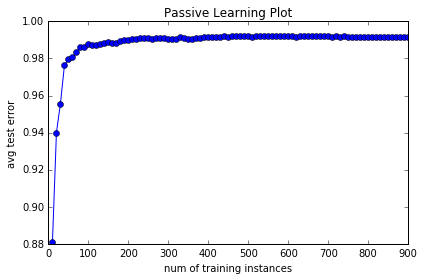

In [57]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1,1,1)

ax1.plot(list(error_dict_passive.keys()), list(error_dict_passive.values()), '-o')
ax1.set_ylabel("avg test error")
ax1.set_xlabel("num of training instances")

plt.title("Passive Learning Plot")
plt.tight_layout()
plt.show()

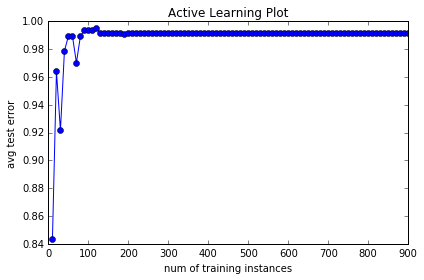

In [58]:
fig2 = plt.figure(1)
ax2 = fig2.add_subplot(1,1,1)

ax2.plot(list(error_dict_active.keys()), list(error_dict_active.values()), '-o')
ax2.set_ylabel("avg test error")
ax2.set_xlabel("num of training instances")

plt.title("Active Learning Plot")
plt.tight_layout()
plt.show()

(2a) - Multi-Class and Multi-Label Classification Using SVM

Anuran Calls (MFCCs) Data Set

source: https://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29#


In [87]:
# Multi-Class and Multi-Label Problem
# each label has multi-class (approach used one versus all)
# classifier for each label

df2 = pd.read_csv(dirpath2 + filename2)
df2 = df2.drop('RecordID', axis=1) # drop RecordID Column

features = df2.columns[:-3]
labels = df2.columns[-3:]

# shuffle the data
np_data2 = np.array(df2)
np.random.shuffle(np_data2)

print("Num of Instances:", df2.shape[0])
print("Num of Features:", len(features))
print("Num of Labels:", len(labels))

X = np_data2[:,np.arange(0,len(features),1)]
y1 = np_data2[:,len(features)] # Family Label
y2 = np_data2[:,len(features)+1] # Genus Label
y3 = np_data2[:,len(features)+2] # Species Label

print("X:", X.shape[0], X.shape[1])
print("y1:", y1.shape[0])
print("y2:", y2.shape[0])
print("y3:", y3.shape[0])

# split size of training (70% train, 30% test)
ssize = math.ceil(0.7*df2.shape[0]) 
X_train, X_test = X[:ssize], X[ssize:]
y1_train, y1_test = y1[:ssize], y1[ssize:]
y2_train, y2_test = y2[:ssize], y2[ssize:]
y3_train, y3_test = y3[:ssize], y3[ssize:]


Num of Instances: 7195
Num of Features: 22
Num of Labels: 3
X: 7195 22
y1: 7195
y2: 7195
y3: 7195


(2b) sec i

Exact Match (accuracy) is ratio of samples that have all their labels correctly classified.

Hamming Score/Loss is ratio of wrong lables to the total number of labels.

source: https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics

source: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html#sklearn.metrics.hamming_loss

(2b) sec ii

In [93]:
# find SVM penalty 'p' and width of Kernel 's'
# using 10-Fold CV with scoring hamming_loss

start_time = time.time()

# y1 SVM Classifer (Family Label)
print("y1 Family Label - SVM Classifier CV Result:")
opt_p1, opt_s1, cv_error1 = procedure_2bii(X_train, y1_train)
print("opt (p,s):", opt_p1, opt_s1, cv_error1)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))

y1 Family Label - SVM Classifier CV Result:
opt (p,s): 6.158482110660261 1.9000000000000001 0.006551563634068605
Elasped time: 00:18:00


In [94]:
start_time = time.time()

# y2 SVM Classifer (Genus Label)
print("y2 Genus Label - SVM Classifier CV Result:")
opt_p2, opt_s2, cv_error2 = procedure_2bii(X_train, y2_train)
print("opt (p,s):", opt_p2, opt_s2, cv_error2)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))

y2 Genus Label - SVM Classifier CV Result:
opt (p,s): 6.158482110660261 1.8000000000000003 0.00833727791978289
Elasped time: 00:18:53


In [95]:
start_time = time.time()

# y3 SVM Classifer (Species Label)
print("y3 Species Label - SVM Classifier CV Result:")
opt_p3, opt_s3, cv_error3 = procedure_2bii(X_train, y3_train)
print("opt (p,s):", opt_p3, opt_s3, cv_error3)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))

y3 Species Label - SVM Classifier CV Result:
opt (p,s): 18.32980710832434 1.6 0.008138470762725235
Elasped time: 00:19:14


In [101]:
print("y1 Family Label - SVM Classifer Test Error:")
print("penalty, width (signma): {:.3f}, {:.3f}".format(opt_p1, opt_s1))
print("test error (hamming_loss): {:.6f}".format(get_test_error_2bii(X_train, y1_train, 
                                                                     X_test, y1_test, 
                                                                     opt_p1, opt_s1)))

print("\ny2 Genus Label - SVM Classifer Test Error:")
print("penalty, width (signma): {:.3f}, {:.3f}".format(opt_p2, opt_s2))
print("test error (hamming_loss): {:.6f}".format(get_test_error_2bii(X_train, y2_train, 
                                                                     X_test, y2_test, 
                                                                     opt_p2, opt_s2)))

print("\ny3 Species Label - SVM Classifer Test Error:")
print("penalty, width (signma): {:.3f}, {:.3f}".format(opt_p3, opt_s3))
print("test error (hamming_loss): {:.6f}".format(get_test_error_2bii(X_train, y3_train, 
                                                                     X_test, y3_test, 
                                                                     opt_p3, opt_s3)))

y1 Family Label - SVM Classifer Test Error:
penalty, width (signma): 6.158, 1.900
test error (hamming_loss): 0.009268

y2 Genus Label - SVM Classifer Test Error:
penalty, width (signma): 6.158, 1.800
test error (hamming_loss): 0.013902

y3 Species Label - SVM Classifer Test Error:
penalty, width (signma): 18.330, 1.600
test error (hamming_loss): 0.012512


(2b) sec iii

In [104]:
# find SVM penalty 'p' for L1-SVM
# using 10-Fold CV with scoring hamming_loss

start_time = time.time()

# y1 SVM Classifer (Family Label)
print("y1 Family Label - SVM L1 Classifier CV Result:")
opt_p1_l1, cv_error1_l1 = procedure_2biii(X_train, y1_train)
print("opt p, cv error:", opt_p1_l1, cv_error1_l1)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))


y1 Family Label - SVM L1 Classifier CV Result:


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


opt p, cv error: 2.069138081114788 0.06432358231563004
Elasped time: 00:04:43


In [105]:
start_time = time.time()

# y2 SVM Classifer (Genus Label)
print("y2 Genus Label - SVM L1 Classifier CV Result:")
opt_p2_l1, cv_error2_l1 = procedure_2biii(X_train, y2_train)
print("opt p, cv error:", opt_p2_l1, cv_error2_l1)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))

y2 Genus Label - SVM L1 Classifier CV Result:


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


opt p, cv error: 6.158482110660261 0.04566253274006753
Elasped time: 00:07:35


In [107]:
start_time = time.time()

# y3 SVM Classifer (Species Label)
print("y3 Species Label - SVM L1 Classifier CV Result:")
opt_p3_l1, cv_error3_l1 = procedure_2biii(X_train, y3_train)
print("opt p, cv error:", opt_p3_l1, cv_error3_l1)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))

y3 Species Label - SVM L1 Classifier CV Result:


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


opt p, cv error: 6.158482110660261 0.041691517561298866
Elasped time: 00:07:28


In [111]:
print("y1 Family Label - SVM L1 Classifer Test Error:")
print("penalty L1: {:.3f}".format(opt_p1_l1))
print("test error (hamming_loss): {:.6f}".format(get_test_error_2biii(X_train, y1_train, 
                                                                     X_test, y1_test, opt_p1_l1)))

print("\ny2 Genus Label - SVM L1 Classifer Test Error:")
print("penalty L1: {:.3f}".format(opt_p2_l1))
print("test error (hamming_loss): {:.6f}".format(get_test_error_2biii(X_train, y2_train, 
                                                                     X_test, y2_test, opt_p2_l1)))

print("\ny3 Species Label - SVM L1 Classifer Test Error:")
print("penalty L1: {:.3f}".format(opt_p3_l1))
print("test error (hamming_loss): {:.6f}".format(get_test_error_2biii(X_train, y3_train, 
                                                                     X_test, y3_test, opt_p3_l1)))

y1 Family Label - SVM L1 Classifer Test Error:
penalty L1: 2.069


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


test error (hamming_loss): 0.063021

y2 Genus Label - SVM L1 Classifer Test Error:
penalty L1: 6.158
test error (hamming_loss): 0.053290

y3 Species Label - SVM L1 Classifer Test Error:
penalty L1: 6.158
test error (hamming_loss): 0.041242


(2b) sec iv

In [113]:
# find SVM penalty 'p' and width of Kernel 's'
# handle class balance using parameter class_weight: 'balanced'
# using 10-Fold CV with scoring hamming_loss

start_time = time.time()

# y1 SVM Balanced Class Classifer (Family Label)
print("y1 Family Label - SVM (Class Balanced) Classifier CV Result:")
opt_p1_bal, opt_s1_bal, cv_error1_bal = procedure_2biv(X_train, y1_train)
print("opt p, s, cv error:", opt_p1_bal, opt_s1_bal, cv_error1_bal)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))

y1 Family Label - SVM (Class Balanced) Classifier CV Result:
opt p, s, cv error: 18.32980710832434 1.9000000000000001 0.006750370791126259
Elasped time: 00:31:12


In [114]:
start_time = time.time()

# y2 SVM Balanced Class Classifer (Genus Label)
print("y2 Genus Label - SVM (Class Balanced) Classifier CV Result:")
opt_p2_bal, opt_s2_bal, cv_error2_bal = procedure_2biv(X_train, y2_train)
print("opt p, s, cv error:", opt_p2_bal, opt_s2_bal, cv_error2_bal)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))

y2 Genus Label - SVM (Class Balanced) Classifier CV Result:
opt p, s, cv error: 18.32980710832434 2.0 0.00873449777525324
Elasped time: 00:51:47


In [115]:
start_time = time.time()

# y3 SVM Balanced Class Classifer (Genus Label)
print("y3 Species Label - SVM (Class Balanced) Classifier CV Result:")
opt_p3_bal, opt_s3_bal, cv_error3_bal = procedure_2biv(X_train, y3_train)
print("opt p, s, cv error:", opt_p3_bal, opt_s3_bal, cv_error3_bal)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))

y3 Species Label - SVM (Class Balanced) Classifier CV Result:
opt p, s, cv error: 54.555947811685144 1.6 0.008138865221370192
Elasped time: 00:46:16


In [116]:
print("y1 Family Label - SVM (Class Balanced) Classifer Test Error:")
print("penalty, width (signma): {:.3f}, {:.3f}".format(opt_p1_bal, opt_s1_bal))
print("test error (hamming_loss): {:.6f}".format(get_test_error_2biv(X_train, y1_train, 
                                                                     X_test, y1_test, 
                                                                     opt_p1_bal, opt_s1_bal)))

print("\ny2 Genus Label - SVM (Class Balanced) Classifer Test Error:")
print("penalty, width (signma): {:.3f}, {:.3f}".format(opt_p2_bal, opt_s2_bal))
print("test error (hamming_loss): {:.6f}".format(get_test_error_2biv(X_train, y2_train, 
                                                                     X_test, y2_test, 
                                                                     opt_p2_bal, opt_s2_bal)))

print("\ny3 Species Label - SVM (Class Balanced) Classifer Test Error:")
print("penalty, width (signma): {:.3f}, {:.3f}".format(opt_p3_bal, opt_s3_bal))
print("test error (hamming_loss): {:.6f}".format(get_test_error_2biv(X_train, y3_train, 
                                                                     X_test, y3_test, 
                                                                     opt_p3_bal, opt_s3_bal)))

y1 Family Label - SVM (Class Balanced) Classifer Test Error:
penalty, width (signma): 18.330, 1.900
test error (hamming_loss): 0.007878

y2 Genus Label - SVM (Class Balanced) Classifer Test Error:
penalty, width (signma): 18.330, 2.000
test error (hamming_loss): 0.013902

y3 Species Label - SVM (Class Balanced) Classifer Test Error:
penalty, width (signma): 54.556, 1.600
test error (hamming_loss): 0.012975


(3a) K-Means Clustering on Multi-Class and Multi-Label

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score, hamming_loss

from scipy import stats


dirpath2 = "/Users/ymkim/Desktop/inf552-hw4-workspace/data/Anuran Calls (MFCCs)/"
filename2 = "Frogs_MFCCs.csv"

df2 = pd.read_csv(dirpath2 + filename2)
df2 = df2.drop('RecordID', axis=1) # drop RecordID Column


features = df2.columns[:-3]
labels = df2.columns[-3:]

print("Num of Instances:", df2.shape[0])
print("Num of Features:", len(features))
print("Num of Labels:", len(labels))

X = np.array(df2[features])
y1 = np.array(df2[labels[0]])
y2 = np.array(df2[labels[1]])
y3 = np.array(df2[labels[2]])


Num of Instances: 7195
Num of Features: 22
Num of Labels: 3


In [8]:
# return k, CH index score
def procedure_3a(X):
    k_list = np.arange(2, 11, 1)
    ch_indx_scores = []
    for k in k_list:
        kmeans_model = KMeans(n_clusters=k).fit(X)
        y_pred = kmeans_model.labels_

        # source: http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index
        # ch_index is higher when clusters are dense and well separated,
        # which relates to a standard concept of a cluster.
        ch_index = calinski_harabaz_score(X, y_pred)
        ch_indx_scores.append(ch_index)

    opt_k = np.argmax(ch_indx_scores) + 2
    return opt_k, ch_indx_scores[opt_k]

(3b)

In [9]:
# return labels assigned to each cluters and data points assigned to each cluter
def procedure_3b(opt_k, X, y1, y2, y3):
    kmeans_model = KMeans(n_clusters=opt_k).fit(X)
    y_pred = kmeans_model.labels_

    # build data_cluster_dict where key is cluster label, value is list of index into X
    data_cluster_dict = {}
    for i in range(len(y_pred)):
        cluster_label = y_pred[i]

        if cluster_label in data_cluster_dict:
            data_cluster_dict[cluster_label].append(i)
        else:
            data_cluster_dict[cluster_label] = [i]
            
    y_true_matrix = [y1, y2, y3]
    
    label_cluster_dict = {}
    # iterate through the data points in each cluster to find majority class label
    for k in data_cluster_dict.keys():
        # print(k, len(data_cluster_dict[k]))

        y_labels_matrix = [[], [], []] # family, genus, species

        # find the majority class in each cluster for each label
        for i in data_cluster_dict[k]:
            # true labels of data in each cluster k
            for j in range(len(y_labels_matrix)):
                y_labels_matrix[j].append(y_true_matrix[j][i])

        # most frequent class for each label in cluster k
        # each index i represents label family, genus, species
        pred_class = []
        for j in range(len(y_labels_matrix)):
            most_freq_class = stats.mode(y_labels_matrix[j], nan_policy='omit')[0][0]
            pred_class.append(most_freq_class)

        label_cluster_dict[k] = pred_class
        
    return label_cluster_dict, data_cluster_dict

(3c)

In [10]:
def procedure_3c(label_cluster_dict, data_cluster_dict, y1, y2, y3):
    y1_pred = np.empty(y1.shape[0], dtype=object)
    y2_pred = np.empty(y2.shape[0], dtype=object)
    y3_pred = np.empty(y3.shape[0], dtype=object)
    
    y_pred_matrix = [y1_pred, y2_pred, y3_pred]
    
    for k in data_cluster_dict.keys():
        # build predicted y1, y2, y3 with majority labels
        for i in data_cluster_dict[k]:
            for j in range(len(y_pred_matrix)):
                y_pred_matrix[j][i] = label_cluster_dict[k][j]
                # print(label_cluster_dict[k][j])

    score1 = hamming_loss(y1, y_pred_matrix[0])
    score2 = hamming_loss(y2, y_pred_matrix[1])
    score3 = hamming_loss(y3, y_pred_matrix[2])
    
    return score1, score2, score3

In [11]:
avg_hamming_score = []

df2 = pd.read_csv(dirpath2 + filename2)
df2 = df2.drop('RecordID', axis=1) # drop RecordID Column

features = df2.columns[:-3]
labels = df2.columns[-3:]

for i in range(50):
    df2 = df2.sample(frac=1)    
    X = np.array(df2[features])
    y1 = np.array(df2[labels[0]])
    y2 = np.array(df2[labels[1]])
    y3 = np.array(df2[labels[2]])

    opt_k, ch_index_score = procedure_3a(X)
    label_cluster_dict, data_cluster_dict = procedure_3b(opt_k, X, y1, y2, y3)
    score1, score2, score3 = procedure_3c(label_cluster_dict, data_cluster_dict, y1, y2, y3)

    avg_score = sum([score1, score2, score3])/3
    avg_hamming_score.append(avg_score)
    
    #print("Iteration:", i+1)
    #print("opt k cluster: {}, CH index score: {}".format(opt_k, ch_index_score))
    #for k in label_cluster_dict.keys():
    #    print("cluter k[{}] have majority labels[family, genus, species]: {}".format(k, label_cluster_dict[k]))
    #print("avg hamming score:", avg_score)
    #print("\n")

hs_mean_50 = np.mean(avg_hamming_score)
hs_std_50 = np.std(avg_hamming_score)

print("(mean, std) of hamming score:", hs_mean_50, hs_std_50)
    
    
    

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


(mean, std) of hamming score: 0.29854065323141077 5.551115123125783e-17


(4) ISLR-10.7.2 see attachments